# Example GSE123139 differential expression

### Dataset
This is an demonstration of differential expression analysis with Normalisr between dysfunctional and naive T cells in human melanoma scRNA-seq. Only a subset of cells were extracted from GSE123139 dataset for this demonstration. You can change it to all the cells by following the guideline in example README.

**Warning**: You will only get the actual results with the **full dataset** of all cells. This example is intended as a demonstration of use for Normalisr, than an exact reproduction of our results in the manuscript.

### Usage
You can get the help of any function by typing ?func in jupyter notebook. For example, the line below shows documentation for function 'open'.

`?open`

To get help for Normalisr, try a specific function such as

`import normalisr.normalisr as norm
?norm.de`

In [1]:
import numpy as np
import normalisr.normalisr as norm
from os.path import join as pjoin
import matplotlib.pyplot as plt
from scipy.io import mmread

diri='../data/de'

### Optional extra logging

In [ ]:
import logging
logging.basicConfig(level=logging.DEBUG)

### Load data

In [2]:
dt0=mmread(pjoin(diri,'0_read.mtx.gz')).astype(int).toarray()
dg=np.loadtxt(pjoin(diri,'0_group.tsv.gz'),delimiter='\t',dtype=int)
if dg.ndim==1:
	dg=dg.reshape(1,-1)
dc=np.loadtxt(pjoin(diri,'0_cov.tsv.gz'),delimiter='\t',dtype=int)
with open(pjoin(diri,'0_gene.txt'),'r') as f:
	namet=np.array([x.strip() for x in f.readlines()])
with open(pjoin(diri,'0_cell.txt'),'r') as f:
	names=np.array([x.strip() for x in f.readlines()])
nameg=np.array([''])
with open(pjoin(diri,'0_cov.txt'),'r') as f:
	namec=np.array([x.strip() for x in f.readlines()])
nc,ng,ns,nt=[len(x) for x in [namec,nameg,names,namet]]
assert dt0.shape==(nt,ns) and dg.shape==(ng,ns) and dc.shape==(nc,ns)

### Initial QC for low read cell and gene removal

In [3]:
select=norm.qc_reads(dt0,0,500,0.02,500,100,0)
print('Genes passed QC: {}/{}'.format(len(select[0]),nt))
print('Cells passed QC: {}/{}'.format(len(select[1]),ns))

dt0=dt0[select[0]][:,select[1]].copy()
dg=dg[:,select[1]].copy()
dc=dc[:,select[1]].copy()
namet=namet[select[0]]
names=names[select[1]]
ns,nt=[len(x) for x in [names,namet]]
assert dt0.shape==(nt,ns) and dg.shape==(ng,ns) and dc.shape==(nc,ns)

Genes passed QC: 2430/27892
Cells passed QC: 7761/7768


### Compute Bayesian logCPM and cellular summary covariates

In [4]:
dt,_,_,dc2=norm.lcpm(dt0)
dc=np.concatenate([dc,dc2],axis=0)

### Normalize covariates and add constant-1 covariate

In [5]:
dc=norm.normcov(dc)

### Compute variance normalization factors for each gene and each cell

In [6]:
sf=norm.scaling_factor(dt0)
weight=norm.compute_var(dt,dc)

### Detect very-low-variance cell outliers

In [7]:
select=norm.qc_outlier(weight)

### Remove very-low-variance cell outliers

In [8]:
print('Cells passed outlier QC: {}/{}'.format(select.sum(),ns))
dt0=dt0[:,select].copy()
dg=dg[:,select].copy()
dt=dt[:,select].copy()
dc=dc[:,select].copy()
weight=weight[select]
names=names[select]
ns=len(names)

Cells passed outlier QC: 7744/7761


### Normalize gene expression at mean and variance levels and covariates at variance level

In [9]:
dt,dc=norm.normvar(dt,dc,weight,sf)

### Perform differential expression test

In [10]:
de=norm.de(dg,dt,dc)

## Visualization
### Histogram

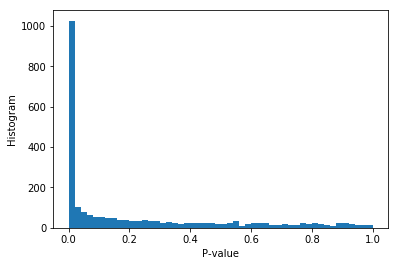

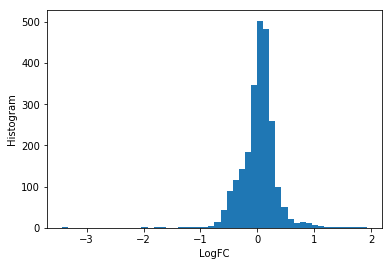

In [11]:
nbin=50

dx=np.linspace(0,1,nbin+1)
tdict=dict(zip(namet,range(len(namet))))

plt.hist(de[0][0],bins=dx);
plt.xlabel('P-value')
plt.ylabel('Histogram')
plt.show()
plt.hist(de[1][0],bins=nbin);
plt.xlabel('LogFC')
plt.ylabel('Histogram');

### Volcano plot

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


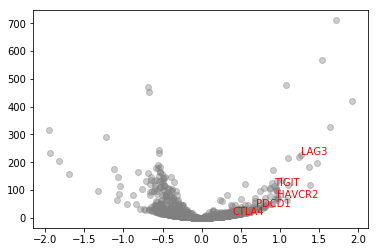

In [12]:
genes=['LAG3','TIGIT','HAVCR2','PDCD1','CTLA4']
color=[0.5]*3
dx=de[1][0]
dy=-np.log(de[0][0])
plt.scatter(dx,dy,color=color,alpha=0.4);
for xi in genes:
	plt.text(dx[tdict[xi]],dy[tdict[xi]],xi,color='red')